<a href="https://colab.research.google.com/github/mojoyinkimberly/Estimating_relative_performance_of_Computers/blob/main/predicting_computer_hardware_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot

Reading the dataset into the python environment

In [243]:
dataset = pd.read_csv("/content/machine.data",sep = ',')
dataset

,adviser,32/60,125,256,6000,256.1,16,128,198,199
0,amdahl,470v/7,29,8000,32000,32,8,32,269,253
1,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
2,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
3,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
4,amdahl,470v/b,26,8000,32000,64,8,32,318,290
...,...,...,...,...,...,...,...,...,...,...
203,sperry,80/8,124,1000,8000,0,1,8,42,37
204,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
205,sratus,32,125,2000,8000,0,2,14,52,41
206,wang,vs-100,480,512,8000,32,0,0,67,47


Renaming columns for better comprehension

In [244]:
renamed_columns=dataset.rename(columns={"adviser":"Vendor name","32/60": "Model Name", "125":"Machine cycle time", "256":"Minimum main memory", "6000":"Maximum main memory", "256.1":"Cache memory","16":"Minimum channel","128":"Maximum channels","198":"Published relative performance","199":"Estimated relative performance"})
renamed_columns

,Vendor name,Model Name,Machine cycle time,Minimum main memory,Maximum main memory,Cache memory,Minimum channel,Maximum channels,Published relative performance,Estimated relative performance
0,amdahl,470v/7,29,8000,32000,32,8,32,269,253
1,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
2,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
3,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
4,amdahl,470v/b,26,8000,32000,64,8,32,318,290
...,...,...,...,...,...,...,...,...,...,...
203,sperry,80/8,124,1000,8000,0,1,8,42,37
204,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
205,sratus,32,125,2000,8000,0,2,14,52,41
206,wang,vs-100,480,512,8000,32,0,0,67,47


Checking for missing values

In [245]:
renamed_columns.isna().sum()

Vendor name                       0
Model Name                        0
Machine cycle time                0
Minimum main memory               0
Maximum main memory               0
Cache memory                      0
Minimum channel                   0
Maximum channels                  0
Published relative performance    0
Estimated relative performance    0
dtype: int64

we have no missing values

Checking for outliers using the describe function

In [246]:
renamed_columns.describe()

,Machine cycle time,Minimum main memory,Maximum main memory,Cache memory,Minimum channel,Maximum channels,Published relative performance,Estimated relative performance
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,204.201923,2880.538462,11824.019231,24.096154,4.644231,17.740385,105.177885,98.850962
std,260.833016,3883.839300,11747.916663,37.417999,6.787198,24.913375,161.090223,154.974961
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,49.500000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,111.500000,99.500000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


It is evident that we have outliers from the variations of the datapoints at the 50th and 75th percentiles

Fixing outliers by filling with the medians any datapoint thats above the 75th percentile 

In [247]:
renamed_columns['Machine cycle time'] = np.where(renamed_columns['Machine cycle time'] > 225.000000, 110.000000, renamed_columns['Machine cycle time'])
renamed_columns['Minimum main memory'] = np.where(renamed_columns['Minimum main memory'] > 4000.000000, 2000.000000, renamed_columns['Minimum main memory'])
renamed_columns['Maximum main memory'] = np.where(renamed_columns['Maximum main memory'] > 16000.000000, 8000.000000, renamed_columns['Maximum main memory'])
renamed_columns['Cache memory'] = np.where(renamed_columns['Cache memory'] > 32.000000, 8.000000, renamed_columns['Cache memory'])
renamed_columns['Minimum channel'] = np.where(renamed_columns['Minimum channel'] > 6.000000, 2.000000, renamed_columns['Minimum channel'])
renamed_columns['Maximum channels'] = np.where(renamed_columns['Maximum channels'] > 24.000000, 8.000000, renamed_columns['Maximum channels'])
renamed_columns['Published relative performance'] = np.where(renamed_columns['Published relative performance'] > 111.500000, 49.500000, renamed_columns['Published relative performance'])
renamed_columns['Estimated relative performance'] = np.where(renamed_columns['Estimated relative performance'] > 99.500000, 45.000000, renamed_columns['Estimated relative performance'])

Checking for outliers to confirm that we have a normalized distribution

In [248]:
renamed_columns.describe()

,Machine cycle time,Minimum main memory,Maximum main memory,Cache memory,Minimum channel,Maximum channels,Published relative performance,Estimated relative performance
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,94.778846,1642.653846,7660.846154,9.144231,2.120192,9.254808,43.447115,41.846154
std,50.255955,1065.822472,4628.230189,10.408022,1.538547,6.821922,21.022236,17.977049
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,49.250000,45.000000
75%,110.000000,2000.000000,8000.000000,8.000000,3.000000,12.000000,49.625000,45.000000
max,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,111.000000,99.000000


Dropping the less important columns that is not necessary for performing our regression analysis.

In [249]:
renamed_columns_up = renamed_columns.drop(columns=['Vendor name','Model Name'])
renamed_columns_up

,Machine cycle time,Minimum main memory,Maximum main memory,Cache memory,Minimum channel,Maximum channels,Published relative performance,Estimated relative performance
0,29.0,2000.0,8000.0,32.0,2.0,8.0,49.5,45.0
1,29.0,2000.0,8000.0,32.0,2.0,8.0,49.5,45.0
2,29.0,2000.0,8000.0,32.0,2.0,8.0,49.5,45.0
3,29.0,2000.0,16000.0,32.0,2.0,16.0,49.5,45.0
4,26.0,2000.0,8000.0,8.0,2.0,8.0,49.5,45.0
...,...,...,...,...,...,...,...,...
203,124.0,1000.0,8000.0,0.0,1.0,8.0,42.0,37.0
204,98.0,1000.0,8000.0,32.0,2.0,8.0,46.0,50.0
205,125.0,2000.0,8000.0,0.0,2.0,14.0,52.0,41.0
206,110.0,512.0,8000.0,32.0,0.0,0.0,67.0,47.0


Checking for the relationship between the dependent and independent variables and also, the relationship among the independent variables to avoid multicollinearity.

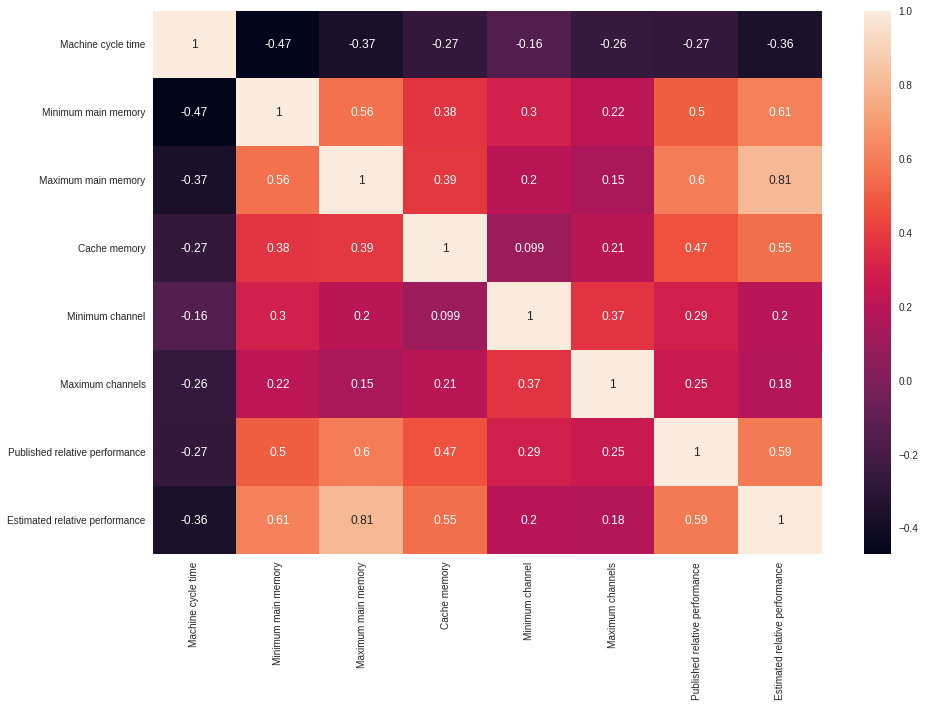

In [250]:
plt.figure(figsize=(15,10))
sns.heatmap(renamed_columns_up.corr(), annot=True)

splitting dataset into dependent and independent variables

In [251]:
y = renamed_columns_up['Estimated relative performance']
x = renamed_columns_up.drop(columns=['Estimated relative performance','Machine cycle time','Cache memory','Minimum channel','Maximum channels','Published relative performance'], axis=1)

Splitting the dataset into train and test and then redoing the split for validation test

In [252]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=45)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Normalizing dataset to avoid bias

In [253]:
new_norm = StandardScaler()
norm_data = new_norm.fit_transform(X_train, y_train)

Depicting dimensionality reduction techniques using Random Forest.This shows the important variables that affect the dependent variable.All other variables should be dropped if found unimportant.

In [254]:
model = RandomForestRegressor(random_state=1, max_depth=4)
model.fit(renamed_columns_up, x)

RandomForestRegressor(max_depth=4, random_state=1)

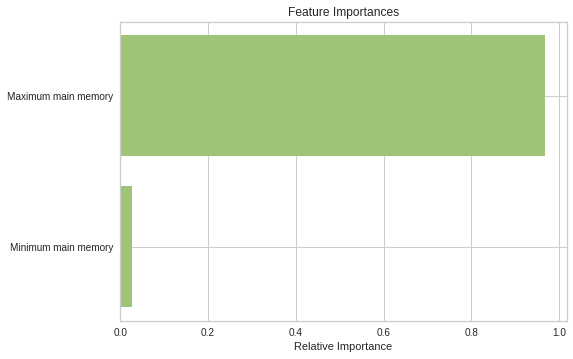

In [255]:
features = renamed_columns_up.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-2:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From the above random forest regressor graph, It is clear that the Maximum main memory and Minimum main memory are the only important variables for predicting the estimated relative performance.Therefore, we would be using just these two variables for our predictions.

Fitting the Linear regression against the validation datasets to check how the model can learn from the data

In [256]:
model = LinearRegression()
power_output = model.fit(X_val, y_val)

Getting our R-squared score.

In [257]:
coef_deter = power_output.score(X_val, y_val)
coef_deter

0.694093381951275

The r-squared score shows how well a model learns from its train dataset

Getting our adjusted R-squared score

In [258]:
1 - (1-model.score(X_val, y_val))*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)

0.6784058630769814

The adjusted r-squared score also shows how well a model learns from its training dataset

In [259]:
intercept = model.coef_
intercept

array([0.00627443, 0.00202395])

The coefficient is measurement used to explain how much variability of our dependent variable can be explained by our independent variable

In [260]:
y_predict = power_output.predict(X_test)

This shows the r-squared score and error scores for the validation dataset on the linear regression model

In [261]:
print("MAE : ",mean_absolute_error(y_test, y_predict))
print("MSE : ",mean_squared_error(y_test, y_predict))
print("R2 score : ",r2_score(y_test, y_predict))

MAE :  5.85822609086811
MSE :  86.5829555184325
R2 score :  0.7419922469888323


Testing the linear regression model with the test dataset to know how good the model can be used to predict the estimated relative performance by comparing the train score against the test score.If the difference between the train and test score is not far apart,it shows that the model is working, but in a case where the difference is a lot,then there is the need to do a pre-diagnosis. 

Plotting a histogram that would show how distributed our data is.

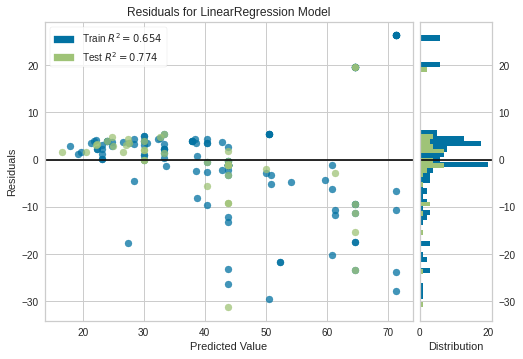

In [262]:
model = LinearRegression()
visualizer = ResidualsPlot(model, hist=True, qqplot=False)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

The above shows that our linear regression model is able to learn from our train dataset given that it can be use to predict the test dataset.

Fitting the Elastic net model against the validation datasets to check how the model can learn from the data

In [282]:
model = ElasticNet()
power_output = model.fit(X_val, y_val)

Getting our R-squared score

In [283]:
coef_deter = power_output.score(X_val, y_val)
coef_deter

0.6940933815962075

The r-squared score shows how well a model learns from its train dataset

Getting our adjusted R-squared score

In [284]:
1 - (1-model.score(X_val, y_val))*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)

0.6784058627037053

The adjusted r-squared score also shows how well a model learns from its training dataset

In [285]:
intercept = model.coef_
intercept

array([0.00627415, 0.00202396])

The coefficient is measurement used to explain how much variability of our dependent variable can be explained by our independent variable

In [267]:
y_predict = power_output.predict(X_test)

The y_predict shows the level at which we can use the train model to predict the test dataset

In [286]:
print("MAE : ",mean_absolute_error(y_test, y_predict))
print("MSE : ",mean_squared_error(y_test, y_predict))
print("R2 score : ",r2_score(y_test, y_predict))

MAE :  5.858301558247847
MSE :  86.58327564409157
R2 score :  0.7419912930493244


Testing the elastic net model with the test dataset to know how good the model can be used to predict the estimated relative performance by comparing the train score against the test score.If the difference between the train and test score is not far apart,it shows that the model is working, but in a case where the difference is a lot,then there is the need to do a pre-diagnosis.


Plotting a histogram that would show how distributed our data is.

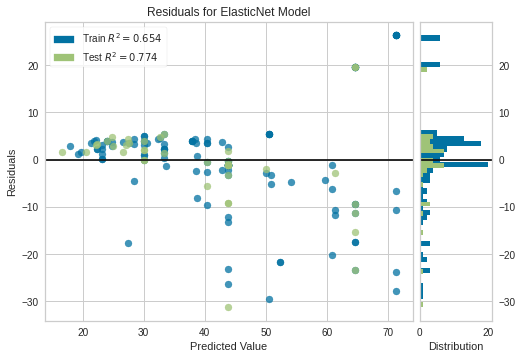

In [287]:
model = ElasticNet()
visualizer = ResidualsPlot(model, hist=True, qqplot=False)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

From the graph above, we can see that our error is normally distributed around zero,and this generally indicates a well fitted model.

Fitting the Ridge model against the validation datasets to check how the model can learn from the data

In [288]:
model_ = Ridge(alpha=5)
power_output_ = model_.fit(X_val, y_val)

Getting our R-squared score.

In [289]:
coef_deter = power_output.score(X_val, y_val)
coef_deter

0.6940933815962075

The r-squared score shows how well a model learns from its train dataset

Getting our adjusted R-squared score

In [290]:
1 - (1-model.score(X_val, y_val))*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)

0.6458180793959452

The adjusted r-squared score also shows how well a model learns from its training dataset

In [291]:
intercept = model.coef_
intercept

array([0.00334153, 0.00260471])

The coefficient is measurement used to explain how much variability of our dependent variable can be explained by our independent variable

In [292]:
y_predict = power_output.predict(X_test)

This shows the r-squared score and error scores for the validation dataset on the ridge model

In [293]:
print("MAE : ",mean_absolute_error(y_test, y_predict))
print("MSE : ",mean_squared_error(y_test, y_predict))
print("R2 score : ",r2_score(y_test, y_predict))

MAE :  5.858301558247847
MSE :  86.58327564409157
R2 score :  0.7419912930493244


Testing the ridge model with the test dataset to know how good the model can be used to predict the estimated relative performance by comparing the train score against the test score.If the difference between the train and test score is not far apart,it shows that the model is working, but in a case where the difference is a lot,then there is the need to do a pre-diagnosis.

Plotting a histogram that would show how distributed our data is.

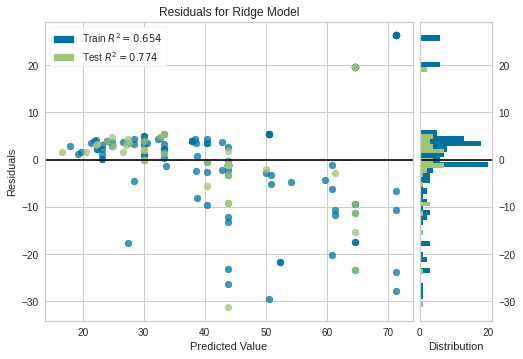

In [294]:
model = Ridge()
visualizer = ResidualsPlot(model, hist=True, qqplot=False)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

From the graph above, we can see that our error is normally distributed around zero,and this generally indicates a well fitted model.

Training the model with the Ridge model since it performs better than the linear regression model and the elastic net regression 

In [295]:
model_ = Ridge()
power_output = model_.fit(X_train, y_train)

Getting our R-squared score.

In [296]:
coef_deter_ = power_output.score(X_train, y_train)
coef_deter_

0.6543061405068857

The r-squared score shows how well a model learns from its train dataset

In [297]:
intercept_ = model.coef_
intercept_

array([0.00334194, 0.00260467])

The coefficient is measurement used to explain how much variability of our dependent variable can be explained by our independent variable

This shows the r-squared score and error scores for the validation dataset on the ridge model

In [298]:
print("MAE : ",mean_absolute_error(y_test, y_predict))
print("MSE : ",mean_squared_error(y_test, y_predict))
print("R2 score : ",r2_score(y_test, y_predict))

MAE :  5.858301558247847
MSE :  86.58327564409157
R2 score :  0.7419912930493244


Testing the ridge model with the train dataset to know how good the model can be used to predict the estimated relative performance by comparing the train score against the test score.If the difference between the train and test score is not far apart,it shows that the model is working, but in a case where the difference is a lot,then there is the need to do a pre-diagnosis.

Plotting a histogram that would show how distributed our data is.

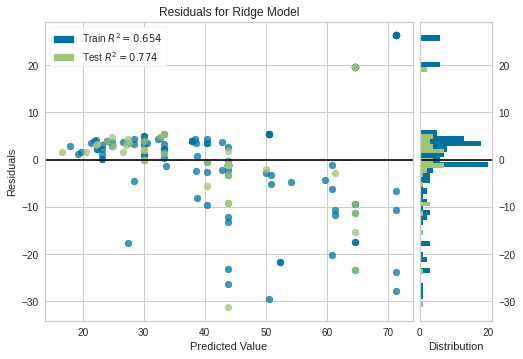

In [299]:
model_1 = Ridge()
visualizer_ = ResidualsPlot(model_1, hist=True, qqplot=False)

visualizer_.fit(X_train, y_train)  
visualizer_.score(X_test, y_test)  
visualizer_.show()

From the R2 score above, it shows that the variables in our regression equation can explain 77% of the change in our output variable.

                      **END OF NOTEBOOK**